In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math ,datetime
from sklearn import preprocessing, model_selection , svm
from sklearn.linear_model import LinearRegression
!pip install quandl
import quandl

import matplotlib.pyplot as plt
from matplotlib import style  
style.use('ggplot')

You should consider upgrading via the 'c:\users\kali\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


0.978218923262505
[1099.99143258 1073.86049177 1020.31203762 1060.6571152  1073.9758382
 1074.05643074 1092.04242545 1112.05551002 1114.95441339 1122.43042395
 1131.4838156  1130.32335224 1149.57149075 1165.11773258 1137.38459528
 1123.30050534 1089.1968274  1102.68192203 1114.10033184 1122.44280461
 1134.98196091 1150.32347655 1181.42938007 1186.42715322 1158.60982956
 1169.23708003 1171.12928306 1154.60009126 1119.93943073 1116.01540611
 1113.1581787  1071.08976444 1042.46085572 1073.86233001 1022.11128495] 0.978218923262505


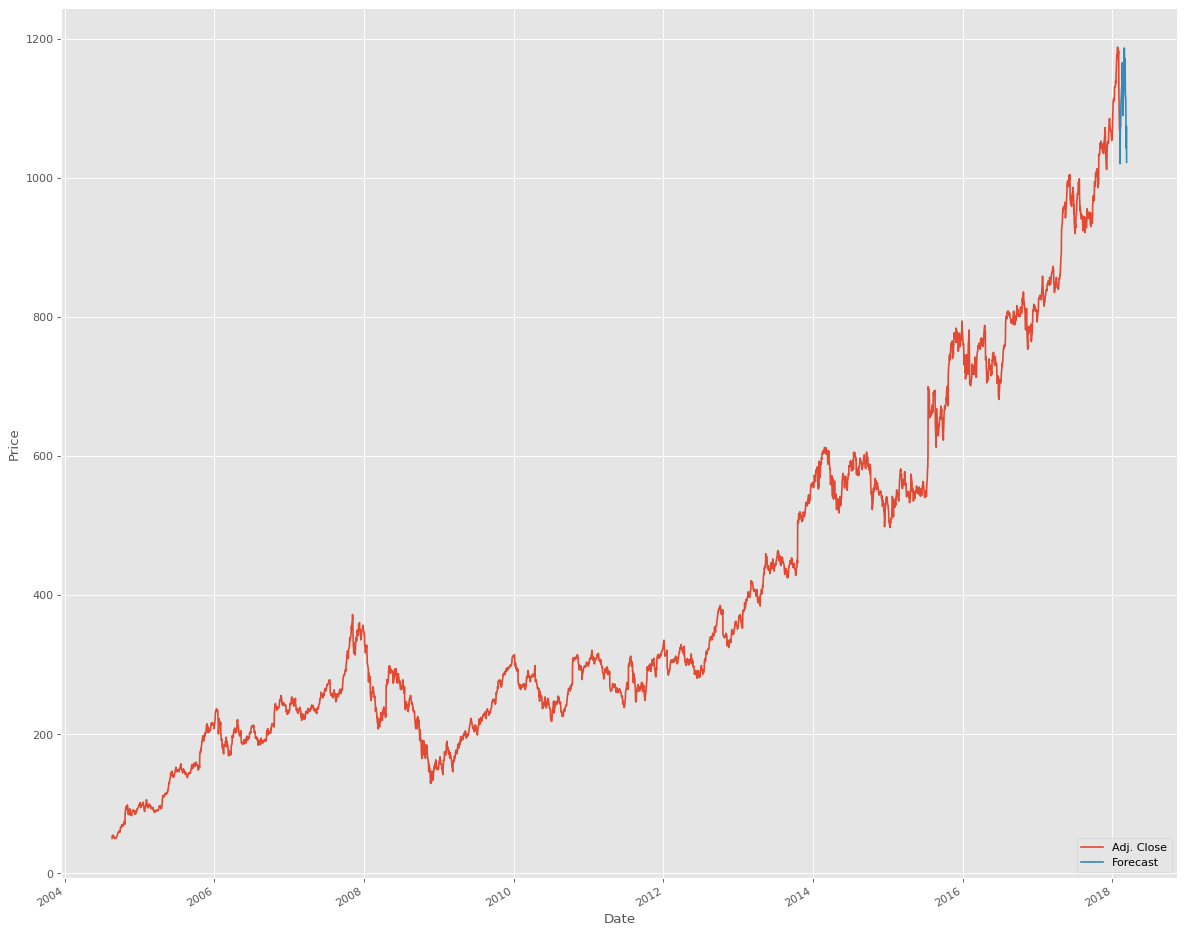

In [2]:
df = quandl.get('WIKI/GOOGL')
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)
forecast_out = int(math.ceil(0.01*len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

#

x = np.array(df.drop(['label'],1))
x = preprocessing.scale(x)
x_lately = x[-forecast_out:]
x = x[:-forecast_out]

df.dropna(inplace=True)
y = np.array(df['label'])

x_train, x_test, y_train, y_test = model_selection.train_test_split (x , y, test_size=0.2)
clf = LinearRegression(n_jobs=-1) #multithreading 
clf.fit(x_train, y_train)
accuracy = clf.score(x_test,y_test)   
forecast_set = clf.predict(x_lately)

print(accuracy)
print(forecast_set, accuracy)

df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

    
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')  
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [3]:
clf = svm.SVR()
clf.fit(x_train, y_train)
accuracy = clf.score(x_test,y_test)   
print(accuracy)

0.7745763306989543


In [4]:
clf = svm.SVR(kernel='linear')
clf.fit(x_train, y_train)
accuracy = clf.score(x_test,y_test)   
print(accuracy)

0.977101543448118


In [5]:
clf = svm.SVR(kernel='poly')
clf.fit(x_train, y_train)
x_plot= clf.predict(x_test)
accuracy = clf.score(x_test,y_test)   
print(accuracy)

0.641948822274818


## OK now to try some stuff on my own.... 

### Holt linear


In [6]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pandas import Series


c:\users\kali\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
c:\users\kali\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  """


<AxesSubplot:>

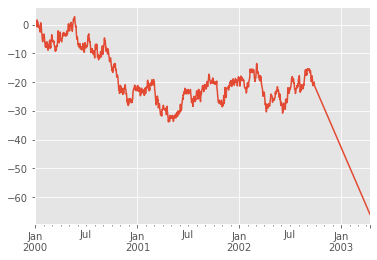

In [7]:
temp = np.random.randn(1000)
ts = Series(temp, index=pd.date_range('1/1/2000', periods=1000))
ts = ts.cumsum()

fit1 = Holt(ts).fit(smoothing_level = 0.3,smoothing_slope = 0.1)#smoothing_level = 0.3,smoothing_slope = 0.1
#forecast = fit1.forecast(200)
predict= fit1.predict(start=1001,end=1200)

#print((predict))

np_ar1 = np.array(ts)
np_ar2 = np.array(predict)
df1 = pd.DataFrame({'ar1':np_ar1})
df2 = pd.DataFrame({'ar2':np_ar2})
qq = pd.concat([df1.ar1, df2.ar2], axis=0)
#temp = np.concatenate(temp,qqq, axis=None)

#print(np_ar2)

ts = Series(np.asarray(qq), index=pd.date_range('1/1/2000', periods=1200))
#print(ts)

ts.plot()

### holtwinters ExponentialSmoothing

<AxesSubplot:xlabel='1949-01'>

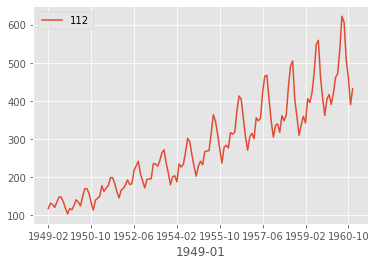

In [8]:
# https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line
# https://stackoverflow.com/questions/50785479/holt-winters-time-series-forecasting-with-statsmodels


from statsmodels.tsa.holtwinters import ExponentialSmoothing


URL = "https://raw.githubusercontent.com/BhavyaGulati/TimeSeries-FlightPassesngerPrediction/master/international-airline-passengers.csv"
df = pd.read_csv(URL, 
#                  parse_dates=0, 
                 index_col=0)
df.plot.line()

# df.index = pd.to_datetime(df.index, format="%G-%w") # https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes

[401.47664151431286, 409.5498264831472, 390.2403152255297, 450.36893779078304, 434.6861280086677, 441.3276673323999, 505.7217397401206, 566.0579637973242, 565.864850088448, 480.1127613240203, 417.0769923941299, 361.999999849922, 401.47664151431286]


c:\users\kali\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\kali\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


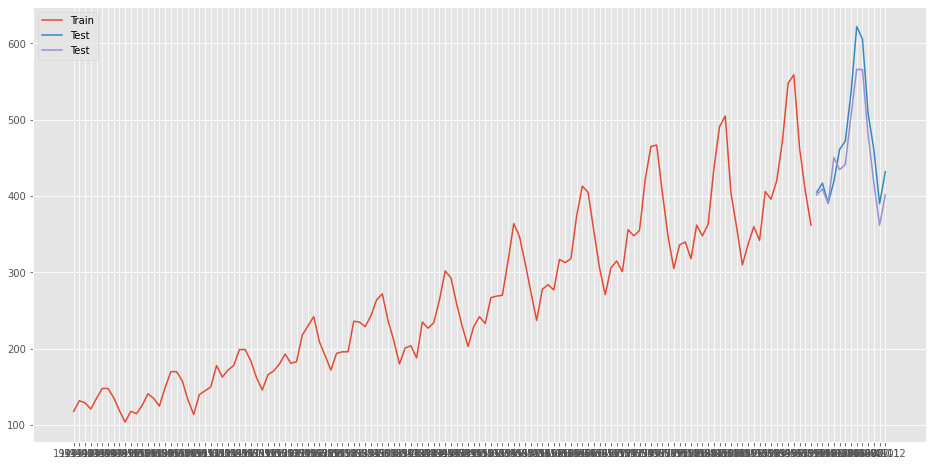

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


train, test = df.iloc[:130, 0], df.iloc[130:, 0]
test = test.drop(test.index[len(test)-1])



train.index.freq = 'MS'
test.index.freq = 'MS'


#train.index = pd.DatetimeIndex(train.index.values,                               freq='MS')
model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

pred.index.freq = 'MS'


list = []
for i in range(len(pred)):
    list.append(pred[i])
    
    
    
print(list)

plt.figure(figsize=(16,8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, pred, label='Test')
#plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')



### ARIMA

ref: [1, for prams](https://stackoverflow.com/questions/44235558/statespace-sarimax-model-why-the-model-use-all-the-data-to-train-mode-and-pred)

[2, docs](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.fit.html#statsmodels.tsa.statespace.sarimax.SARIMAX.fit)

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
# # https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

c:\users\kali\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\kali\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


mean_squared_error:  251.52870899556717


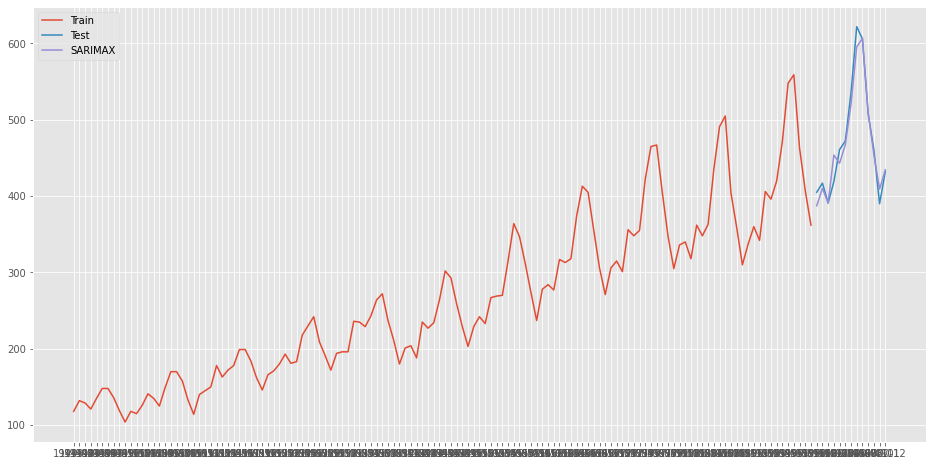

In [13]:
y_hat_avg = [0]

train, test = df.iloc[:130, 0], df.iloc[130:, 0]
test = test.drop(test.index[len(test)-1])

train.index.freq = 'MS'
test.index.freq = 'MS'
pred.index.freq = 'MS'


model = SARIMAX(train,order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit() #order=(2, 1, 4),seasonal_order=(0,1,1,7)

pred = model.predict(start=test.index[0], end=test.index[-1])#dynamic=True

mylist = [pred[i] for i in range(len(pred))]
#print(mylist)


plt.figure(figsize=(16,8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, mylist, label='SARIMAX')
plt.legend()

error = mean_squared_error(test, pred)
print("mean_squared_error: ",error)

In [12]:
#plt.figure(figsize=(16,8))
#plt.plot(ts, label="ts")
#plt.plot(np_ar2, label="holt")
#plt.legend(loc='best')
#plt.show()